# Model

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import BasicBlock, Bottleneck
from transformers import SamModel, SamProcessor

In [24]:
class Processor:
    def __init__(self):
        self.processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

    def preprocess(self, image):
        inputs = self.processor(image, return_tensors="pt")
        return inputs

    def postprocess(self, inputs, outputs):
        h, w = inputs['original_sizes'][0]

        resized = F.interpolate(
            outputs, size=(h, w),
            mode="bilinear", align_corners=True
        )

        resized = resized.squeeze(1)
        resized *= 255
        return resized


In [25]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.sam = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")
        self.encoder = self.image_encoder
        self.decoder = self.initialize_decoder()

        # Freeze SAM encoder
        for param in self.sam.parameters():
            param.requires_grad = False

    def image_encoder(self, inputs):
        # Extract image embeddings using SAM
        # 256 x 64 x 64
        return self.sam.get_image_embeddings(inputs["pixel_values"])

    def initialize_decoder(self, use_bottleneck=False):
        # Choose block type: BasicBlock or Bottleneck
        Block = Bottleneck if use_bottleneck else BasicBlock

        upscale = nn.Sequential(
            # Upsample 256 x 64 x 64 -> 128 x 128 x 128
            nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2)),
            nn.ReLU(),
            Block(inplanes=128, planes=128),  # Residual Block

            # Upsample 128 x 128 x 128 -> 64 x 256 x 256
            nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2)),
            nn.ReLU(),
            Block(inplanes=64, planes=64),  # Residual Block

            # Reduce channels 64 x 256 x 256 -> 32 x 256 x 256
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            Block(inplanes=32, planes=32),  # Residual Block

            # Final output 32 x 256 x 256 -> 1 x 256 x 256
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        return upscale

    def forward(self, inputs):
        embeddings = self.encoder(inputs)
        depth = self.decoder(embeddings)
        return depth


In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Network().to(device)
processor = Processor()

# Load Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

# Dataset
# https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2

# Dataset and DataLoader Reference
# https://www.kaggle.com/code/shreydan/monocular-depth-estimation-nyuv2

Mounted at /content/drive


In [7]:
import os
from pathlib import Path
os.chdir('/content/drive/MyDrive/Depth Estimation')

In [8]:
import pandas as pd

base_path = Path("/content/drive/MyDrive/Depth Estimation/")
train_csv = base_path / Path("data/nyu2_train.csv")

In [9]:
df = pd.read_csv(train_csv, header=None)
df[0] = df[0].map(lambda x: base_path / x)
df[1] = df[1].map(lambda x: base_path / x)

We trained the model for 1 epoch.

The number of training data is approximately 50000.

We divided it into several parts and trained them multiple times to construct 1 epoch.

This is because learning 1 epoch took too long for our computational resources.

In [10]:
cnt = 7
start = [ 0, 5000, 10000, 15000, 20000, 25000, 30000 ]
end   = [ 5000, 10000, 15000, 20000, 25000, 30000, len(df) ]

In [11]:
from sklearn.model_selection import train_test_split

new_df = pd.DataFrame()

for i in range(cnt):
    __df = df.iloc[start[i]:end[i]]
    train_df, val_df = train_test_split(__df,test_size=0.1,shuffle=False)
    val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=False)

    new_df = pd.concat([new_df, test_df], ignore_index=True)


In [12]:
len(new_df)

507

In [13]:
df = new_df

# Load Test Data

Test images with no ground truth

In [14]:
test_csv = base_path / Path("data/nyu2_test.csv")
test_df = pd.read_csv(train_csv, header=None)
test_df[0] = test_df[0].map(lambda x: base_path / x)
test_df[1] = test_df[1].map(lambda x: base_path / x)

# Utility

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None: d_min = np.min(depth)
    if d_max is None: d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])

    return img_merge

# Dataset

In [16]:
import cv2 as cv

class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im

    def __len__(self,):
        return len(self.df)

    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        dp = dp.astype('float32')

        return im, dp

In [17]:
import albumentations as A

tfms = A.Compose([ ])
dataset = Dataset(df,tfms)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [18]:
test_dataset = Dataset(test_df,tfms)

# Evaluation

We use absolute relative difference as an evaluation metric.

In [ ]:
def abs_rel(pred, depth):
    loss = np.mean(np.abs(pred - depth) / depth)
    return loss

In [ ]:
def mse(pred, depth):
    loss = np.mean((pred - depth) ** 2)
    return loss

## 1. Our Model

In [ ]:
load_path = base_path / "model/final.pth"
model.load_state_dict(torch.load(load_path))

<ipython-input-46-5240e705c647>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


<All keys matched successfully>

In [ ]:
def evaluate(image, depth, loss_func):
    input = processor.preprocess(image).to(device)
    output = model(input)
    pred = processor.postprocess(input, output)

    pred = pred.squeeze(0)
    pred = pred.cpu().detach().numpy()

    loss = loss_func(pred, depth)
    return loss

### Quantitative Result

In [ ]:
model.eval()
abs_rel_loss = 0
mse_loss = 0

for i in range(len(df)):
    with torch.no_grad():
        img, depth = dataset[i]
        abs_rel_loss += evaluate(img, depth, abs_rel)
        mse_loss += evaluate(img, depth, mse)

    if (i % 50 == 0):
        print(abs_rel_loss, mse_loss)

print()
abs_rel_loss /= len(df)
mse_loss /= len(df)

rmse_loss = np.sqrt(mse_loss)
print(abs_rel_loss, rmse_loss)


1.0331748723983765 0.024905426427721977
47.15961307287216 1.1850027088075876
66.60079790651798 1.8304536661598831
92.0264268964529 2.7480101448018104
114.49480621516705 3.5479642061982304
146.61299027502537 4.4106008757371455
170.154600456357 5.6629525946918875
187.2082278430462 6.398333557182923
202.99747912585735 7.12305305688642
217.99874991178513 7.810411124723032
233.10618226230145 8.546078193699941

0.4629208482581483 0.1306434251215079


### Qualitative Result

#### Images with ground truth

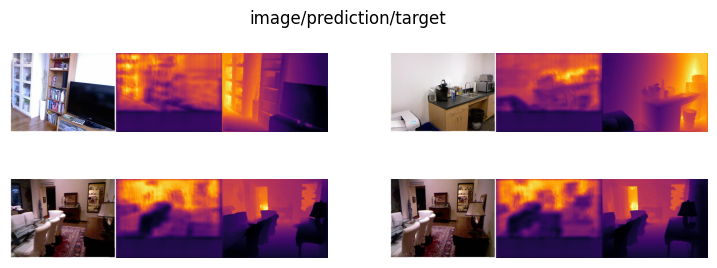

In [ ]:
plt.figure(figsize=(9, 3))
r, c = 2, 2
selection = [100, 200, 300, 400]

with torch.no_grad():
    for i, idx in enumerate(selection):
        img, depth = dataset[idx]

        input = processor.preprocess(img).to(device)
        outputs = model(input)
        pred = processor.postprocess(input, outputs)
        pred = pred.squeeze(0).cpu().numpy()

        depth = colored_depthmap(depth)
        pred = colored_depthmap(pred)

        image_viz = np.hstack([img, pred, depth])
        ax = plt.subplot(r, c, i + 1)
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")

    title = "image/prediction/target"
    plt.suptitle(title)
    plt.show()

#### Images without ground truth

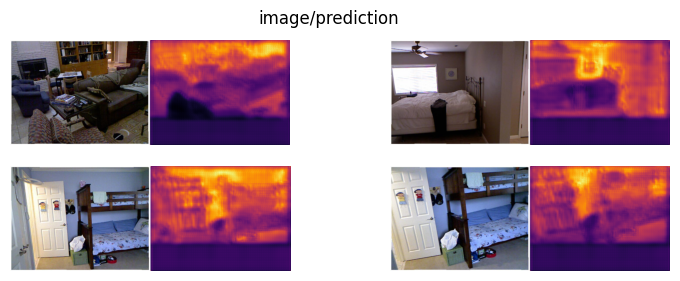

In [ ]:
plt.figure(figsize=(9, 3))
r, c = 2, 2
selection = [100, 200, 300, 400]

with torch.no_grad():
    for i, idx in enumerate(selection):
        img, depth = test_dataset[idx]

        input = processor.preprocess(img).to(device)
        outputs = model(input)
        pred = processor.postprocess(input, outputs)
        pred = pred.squeeze(0).cpu().numpy()

        pred = colored_depthmap(pred)

        image_viz = np.hstack([img, pred])
        ax = plt.subplot(r, c, i + 1)
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")

    title = "image/prediction"
    plt.suptitle(title)
    plt.show()

# 2. Depth Anything

In [30]:
from transformers import pipeline
from PIL import Image

# load model
depth_anything = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf", device=device)

In [31]:
import requests

url = "https://raw.githubusercontent.com/DepthAnything/Depth-Anything-V2/refs/heads/main/assets/examples/demo01.jpg"
response = requests.get(url, stream=True)
image = Image.open(response.raw)
depth = depth_anything(image)['depth']

In [ ]:
image = np.array(image)
depth = colored_depthmap(depth).astype("uint8")

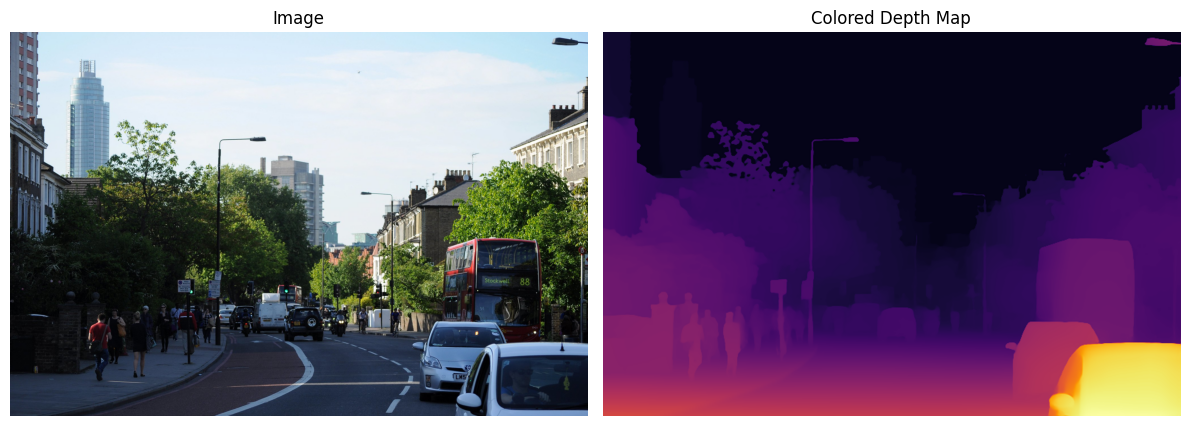

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].imshow(depth)
axes[1].set_title("Colored Depth Map")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [35]:
# pred = 1 / (scale * pred + shift)
# Apply linear regression to find optimal value of scale and shift ...

scale, shift = 0, 0

for i in range(len(df)):
    img, depth = dataset[i]
    img = Image.fromarray(img)
    pred = depth_anything(img)['predicted_depth']
    pred = pred.cpu().detach().numpy()

    A, B = 1 / depth, pred

    A_mean, B_mean = np.mean(A), np.mean(B)

    sc = np.sum((B - B_mean) * (A - A_mean)) / np.sum((B - B_mean) ** 2)
    sh = A_mean - sc * B_mean

    scale += sc
    shift += sh

scale /= len(df)
shift /= len(df)

print(scale, shift)

0.8105442858424178 2.401557074025773


In [ ]:
scale, shift = 0.8105584977293862, 2.4015101518856703

In [ ]:
import PIL

def depth_anything_evaluate(image, depth, loss_func):
    image = Image.fromarray(image)
    pred = depth_anything(image)['predicted_depth']
    pred = pred.cpu().detach().numpy()
    pred = 1 / (scale * pred + shift)
    loss = loss_func(pred, depth)
    return loss


### Quantitative Result

In [ ]:
abs_rel_loss = 0
mse_loss = 0

for i in range(len(df)):
    image, depth = dataset[i]
    abs_rel_loss += depth_anything_evaluate(image, depth, abs_rel)
    mse_loss += depth_anything_evaluate(image, depth, mse)

    if (i % 50 == 0):
        print(abs_rel_loss, mse_loss)

print()
abs_rel_loss /= len(df)
mse_loss /= len(df)

rmse_loss = np.sqrt(mse_loss)
print(abs_rel_loss, rmse_loss)

0.7553924918174744 0.015193280763924122
28.52729445695877 0.44714709650725126
37.476639561355114 0.9446502750506625
47.725210912525654 1.2092394474311732
57.71789116412401 1.7693580343620852
68.16875703260303 1.8831920812372118
80.70019281283021 2.6554117924533784
92.5268330834806 3.3711096228216775
104.2140240073204 4.099011301237624
115.10428258776665 4.837728553742636
126.8583450652659 5.666701772599481

0.253436174361252 0.10710405900880979


### Qualitative Result

#### Images with ground truth

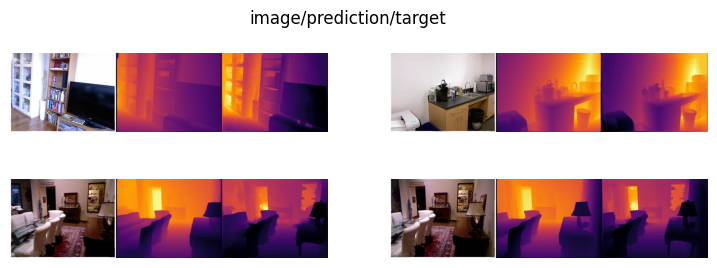

In [ ]:
plt.figure(figsize=(9, 3))
r, c = 2, 2
selection = [100, 200, 300, 400]

for i, idx in enumerate(selection):
    img, depth = dataset[idx]
    img = Image.fromarray(img)
    pred = depth_anything(img)['predicted_depth']
    pred = pred.cpu().detach().numpy()
    pred = 1 / (scale * pred + shift)

    depth = colored_depthmap(depth)
    pred = colored_depthmap(pred)

    image_viz = np.hstack([img, pred, depth])
    ax = plt.subplot(r, c, i + 1)
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

title = "image/prediction/target"
plt.suptitle(title)
plt.show()

#### Images without ground truth

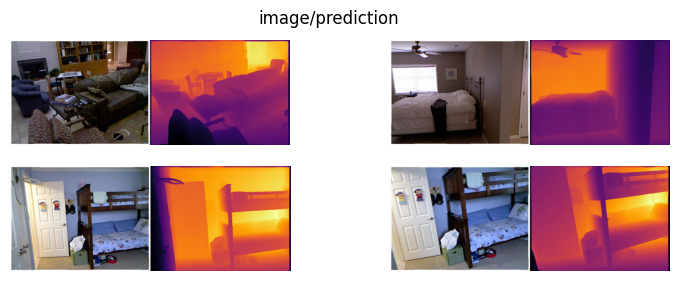

In [ ]:
plt.figure(figsize=(9, 3))
r, c = 2, 2
selection = [100, 200, 300, 400]

with torch.no_grad():
    for i, idx in enumerate(selection):
        img, depth = test_dataset[idx]

        img = Image.fromarray(img)
        pred = depth_anything(img)['predicted_depth']
        pred = pred.cpu().detach().numpy()
        pred = 1 / (scale * pred + shift)
        pred = colored_depthmap(pred)

        image_viz = np.hstack([img, pred])
        ax = plt.subplot(r, c, i + 1)
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")

    title = "image/prediction"
    plt.suptitle(title)
    plt.show()